## Sentiment Analysis

In this exercise we use the IMDb-dataset, which we will use to perform a sentiment analysis. The code below assumes that the data is placed in the same folder as this notebook. We see that the reviews are loaded as a pandas dataframe, and print the beginning of the first few reviews.

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kubak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Positive reviews count:  12500
Negative reviews count:  12500


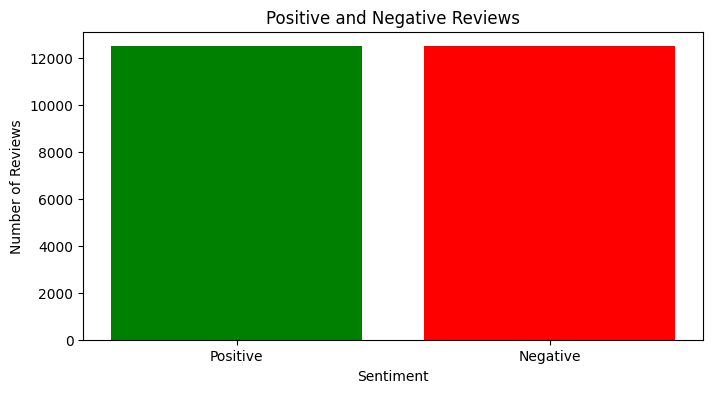

                                              ReviewText  Label
0      bromwell high is a cartoon comedy . it ran at ...      1
1      story of a man who has unnatural feelings for ...      0
2      homelessness  or houselessness as george carli...      1
3      airport    starts as a brand new luxury    pla...      0
4      brilliant over  acting by lesley ann warren . ...      1
...                                                  ...    ...
24995  i saw  descent  last night at the stockholm fi...      0
24996  a christmas together actually came before my t...      1
24997  some films that you pick up for a pound turn o...      0
24998  working  class romantic drama from director ma...      1
24999  this is one of the dumbest films  i  ve ever s...      0

[25000 rows x 2 columns]


In [45]:
import numpy as np
import pandas as pd
import re
import string
string.punctuation
from gensim import corpora
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
import nltk
from gensim.models import Word2Vec
from sklearn.metrics import accuracy_score
nltk.download('punkt')

reviews = pd.read_csv('reviews.txt', header=None)
labels = pd.read_csv('labels.txt', header=None)

reviews.columns = ['ReviewText']
labels.columns = ['Label']

Y = (labels['Label']=='positive').astype(np.int_)


positive_reviews_count = Y.sum()
negative_reviews_count = Y.size - positive_reviews_count

data = pd.concat([reviews, Y], axis=1)

print("Positive reviews count: ", positive_reviews_count)
print("Negative reviews count: ", negative_reviews_count)

plt.figure(figsize=(8, 4))
plt.bar(['Positive', 'Negative'], [positive_reviews_count, negative_reviews_count], color=['green', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.title('Positive and Negative Reviews')
plt.show()

print(data)

Y = Y.values.reshape(-1, 1)

**(a)** Split the reviews and labels in test, train and validation sets. The train and validation sets will be used to train your model and tune hyperparameters, the test set will be saved for testing. Use the `CountVectorizer` from `sklearn.feature_extraction.text` to create a Bag-of-Words representation of the reviews. Only use the 10,000 most frequent words (use the `max_features`-parameter of `CountVectorizer`).

**(b)** Explore the representation of the reviews. How is a single word represented? How about a whole review?

**(c)** Train a neural network with a single hidden layer on the dataset, tuning the relevant hyperparameters to optimize accuracy. 

**(d)** Test your sentiment-classifier on the test set.

**(e)** Use the classifier to classify a few sentences you write yourselves. 

In [46]:
stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself",
              "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself",
              "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these",
              "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do",
              "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while",
              "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before",
              "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again",
              "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each",
              "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than",
              "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]


Cleaning text

In [47]:
#Removing stop words
cleaned_reviews = []
reviews_sentences_tokenized = []
reviews_words_tokenized = []
pattern = r'\b(' + '|'.join(stop_words) + r')\b'
for i, review in enumerate(data['ReviewText']):
    review = re.sub(pattern, '', review, flags=re.IGNORECASE)
    reviews_sentences_tokenized.append(sent_tokenize(review))
    review = re.sub(r'[^\w\s]', '', review)
    data.at[i, 'ReviewText'] = review
    cleaned_reviews.append(review)
    reviews_words_tokenized.append(word_tokenize(review))
print(cleaned_reviews[0])

bromwell high   cartoon comedy   ran    time    programs  school life     teachers      years   teaching profession lead   believe  bromwell high   satire  much closer  reality    teachers    scramble  survive financially   insightful students   see right   pathetic teachers  pomp   pettiness   whole situation   remind    schools  knew   students    saw  episode    student repeatedly tried  burn   school   immediately recalled                     high   classic line inspector   m   sack one   teachers  student welcome  bromwell high   expect  many adults   age think  bromwell high  far fetched    pity   isn     


Building dictionary

In [37]:
mydict = corpora.Dictionary(reviews_words_tokenized)
print("Total unique words:")
print(len(mydict.token2id))
print("\nSample data from dictionary:")
i = 0
# Print top 4 (word, id) tuples
for key in mydict.token2id.keys():
    print("Word: {} - ID: {} ".format(key, mydict.token2id[key]))
    if i == 3:
        break
    i += 1

Total unique words:
73944

Sample data from dictionary:
Word: adults - ID: 0 
Word: age - ID: 1 
Word: believe - ID: 2 
Word: bromwell - ID: 3 


Train-Test-Validation Split

['aaron' 'abandon' 'abandoned' ... 'zoom' 'zorro' 'zu']
br               91696
movie            39676
film             36148
one              24134
like             18173
                 ...  
charity             27
misfits             27
domination          27
archaeologist       27
willem              27
Length: 10000, dtype: int64


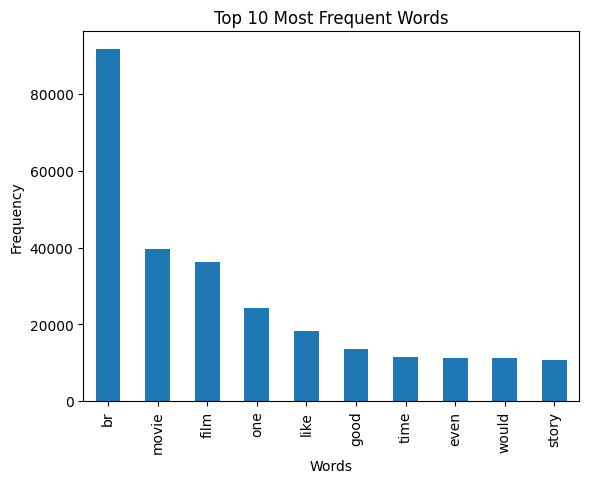

Shape of X_train_temp_tfidf: (22500, 10000)


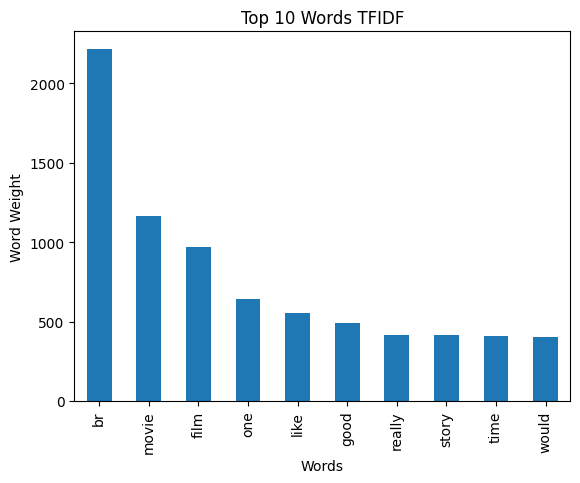

In [48]:
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(cleaned_reviews, Y, test_size=0.1, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

vectorizer = CountVectorizer(max_features=10000, stop_words=stop_words)
#Vectorizing train data
count_matrix = vectorizer.fit_transform(X_train_temp)
X_train_temp_count = count_matrix.toarray()

df_count_vectorizer = pd.DataFrame(data=X_train_temp_count, columns = vectorizer.get_feature_names_out())
print(vectorizer.get_feature_names_out())

word_frequencies = df_count_vectorizer.sum(axis=0).sort_values(ascending=False)
print(word_frequencies)

word_frequencies.head(10).plot(kind='bar')
plt.title('Top 10 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

#TFIDF

tfidf_vectorizer = TfidfVectorizer(max_features=10000, analyzer='word' , stop_words=stop_words)
tfidf_matrix = tfidf_vectorizer.fit_transform(X_train_temp)
X_train_temp_tfidf = tfidf_matrix.toarray()

print("Shape of X_train_temp_tfidf:", X_train_temp_tfidf.shape)

#Vectorizing validation and test data
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

df_tfid = pd.DataFrame(data=X_train_temp_tfidf, columns = tfidf_vectorizer.get_feature_names_out())
tfidf_words = df_tfid.sum(axis=0).sort_values(ascending=False)

tfidf_words.head(10).plot(kind='bar')
plt.title('Top 10 Words TFIDF')
plt.xlabel('Words')
plt.ylabel('Word Weight')
plt.show()

Sigmoid activation function

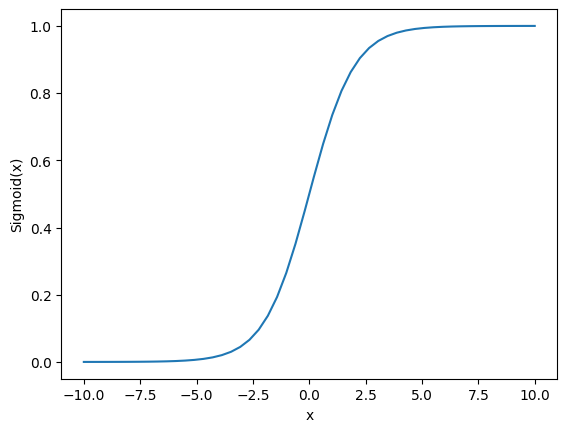

In [7]:
def sig(x):
 return 1/(1 + np.exp(-x))

x = np.linspace(-10, 10, 50)   
p = sig(x)
plt.xlabel("x") 
plt.ylabel("Sigmoid(x)")  
plt.plot(x, p) 
plt.show()

Neural Network Structure

In [49]:
def layer_sizes(X,Y):
    n_x = X.shape[0]
    n_y = Y.shape[0]

    return(n_x, n_y)


Parameter initialization

In [50]:
def initialize_parameters(n_x, n_h, n_y):
    
    #*0.01 too decrease the learning time
    W1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h)*0.01
    b2 = np.zeros((n_y, 1))

    parameters = {
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2,
    }

    return parameters

Forward propagation

![title](forward_propagation.png) 

Source: https://medium.com/@pdquant/all-the-backpropagation-derivatives-d5275f727f60

![title](sigmoid.png)
Source: https://en.wikipedia.org/wiki/Sigmoid_function

In [51]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']

    Z1 = np.dot(W1, X) + b1
    #Tanh activation function (hyperbolic tangent), result between -1 and 1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    #Sigmoid activation function, result between 0 and 1
    A2 = 1 / (1 + np.exp(-Z2))

    cache = {
        'Z1': Z1,
        'A1': A1,
        'Z2': Z2,
        'A2': A2
    }

    return A2, cache

Cost function

In [52]:
def compute_cost(A2, Y):
    m = Y.shape[1]

    logprobs = np.multiply(np.log(A2), Y) + np.multiply((1-Y), np.log(1-A2))
    cost = - np.sum(logprobs) / m

    cost = float(np.squeeze(cost))

    return cost

Backward propagation

![title](derivatives.png) 

Image taken from: https://medium.com/@pdquant/all-the-backpropagation-derivatives-d5275f727f60

In [53]:
def backward_propagation(parameters, cache, X, Y):
    
    m = Y.shape[1]

    W1 = parameters['W1']
    A1 = cache['A1']
    W2 = parameters['W2']
    A2 = cache['A2']

    dZ2 = A2 - Y
    dW2 = (1/m) * np.dot(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)

    dZ1 = np.dot(W2.T, dZ2)*(1 - np.power(A1, 2))
    #X is used instead of A1 because W[1]W[1] connects the input layer directly to the first hidden layer
    dW1 = (1/m) * np.dot(dZ1, X.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)

    grads = {'dW1': dW1,'db1': db1,'dW2': dW2,'db2': db2,}
    return grads

Gradient descent

In [54]:
def update_parameters(parameters, grads, learning_rate):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']

    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']

    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2

    parameters = {
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2
    }
    
    return parameters


Neural Network Model

In [60]:
#n_h - number of hidden layers

def nn_model(X, Y, n_h, num_iterations, print_cost, learning_rate):
    
    print(Y.shape)
    print(X.shape) 


    n_x = X.shape[1] # Number of features
    n_y = Y.shape[1] # Number of output units

    parameters = initialize_parameters(n_x, n_h, n_y)

    for i in range(0, num_iterations):
        #forward propagation
        A2, cache = forward_propagation(X.T, parameters)
        #cost function
        cost = compute_cost(A2, Y)
        #Backpropagation
        grads = backward_propagation(parameters, cache, X.T, Y.T)
        #Gradient descent
        parameters = update_parameters(parameters, grads, learning_rate)

        if print_cost and i % 1000 == 0:
            print(f'Cost after iteration {i}: {cost}')
    return parameters

In [92]:
parameters = nn_model(X_train_temp_tfidf, y_train_temp, n_h =1, num_iterations=100, learning_rate=1, print_cost=True)

(22500, 1)
(22500, 10000)
Cost after iteration 0: 350905754.2551034


Prediction function

In [102]:
def predict(parameters, X):
    A2, cache = forward_propagation(X.T, parameters)
    prediction = A2>0.5
    return prediction

Review predictions

In [111]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

predictions = predict(parameters, X_val_tfidf.toarray())
accuracy = accuracy_score(y_val, predictions[0])
precision_score = precision_score(y_val, predictions[0])
recall_score = recall_score(y_val, predictions[0])
f1_score = f1_score(y_val, predictions[0])
print(f'Accuracy: {accuracy}')
print(f'Precision_score: {precision_score}')
print(f'recall_score: {recall_score}')
print(f'f1_score: {f1_score}')

Accuracy: 0.4936
Precision_score: 0.0
recall_score: 0.0
f1_score: 0.0


c:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy for num_iterations=1 - 0.4936

Random review predictions

In [83]:
random_reviews = ['It was not bad at all', 'It was bad', 'It was absolutely freaking awesome']
random_reviews_tfidf = tfidf_vectorizer.transform(random_reviews)

#print("Shape of X_val_tfidf:", X_val_tfidf.shape)
print("Shape of random_reviews_tfidf:", random_reviews_tfidf.shape)

predictions = predict(parameters, random_reviews_tfidf.toarray())
print(predictions)


Shape of random_reviews_tfidf: (3, 10000)
[[False False False]]
